# Initialization

In [ ]:
ls

FIFA 2018 Statistics.csv
algo.ipynb
house-prices-advanced-regression-techniques/


In [ ]:
cd Documents/UM/22_23/Project 2/code

/Users/leon/Documents/UM/22_23/Project 2/code


# Basic Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

shape = (100, 16)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input
#print(X)


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_

(0.9993316174977624,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

In [ ]:
import itertools
import math

def divisive_shap_approx(X, y, model, beta, gamma_n, gamma_d, num_partitions):
    if X.shape[1] > np.emath.logn(beta, n):
        partitions = []
        sum_gamma_n = 0
        sum_gamma_d = 0
        for _ in range(num_partitions):
            split_S = partition(X,y)
            partitions.append(split_S)
            sum_gamma_n += value(X, y, model)
            sum_gamma_d += sum([value(Xi, yi, model) for Xi, yi in split_S])
        gamma_n = gamma_n * (sum_gamma_n / num_partitions)
        gamma_d = gamma_d * (sum_gamma_d / num_partitions)
        return union([divisive_shap_approx(Xi, 
                                           yi, 
                                           model,
                                           beta,
                                           gamma_n, 
                                           gamma_d,
                                           num_partitions) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)

def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)
        return reg.score(X, y)
        

def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def partition(X, y):
    """Returns list of tuples: [(X1, Y1), (X2, Y2), ...]"""
    #N = X.shape[1]
    #return [(X[:,:N//2], y), (X[:,N//2:], y)]

    split_results = []
    X_train, X_test = train_test_split(X.T, test_size=0.5, )#random_state=42)
    return [(X_train.T, y), (X_test.T, y)]

def union(S_split):
    """Returns the union of several sets (Xi, Yi, Shapi)"""
    X = S_split[0][0]
    y = S_split[0][1]
    shap = S_split[0][2]
    for Xi, _, shapi in S_split[1:]:
        X = np.concatenate((X, Xi), axis=1)
        shap = np.concatenate((shap, shapi))
    return (X, y, shap)


In [ ]:
def main(X, y, model, beta, num_partitions = 1):
    X2, y2, shap = divisive_shap_approx(X, y, model, beta, 1, 1, num_partitions)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)

## Examples

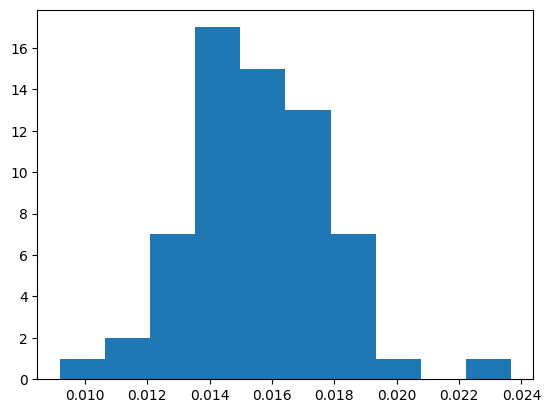

In [ ]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()


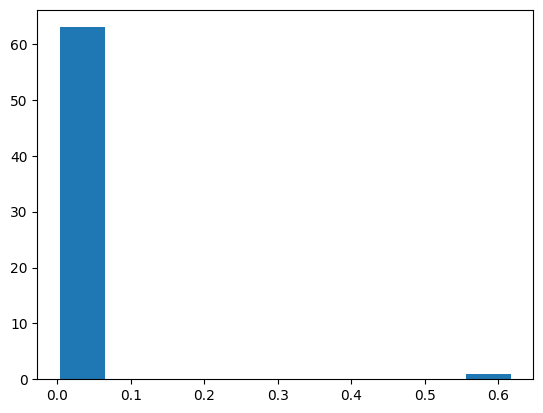

In [ ]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
X[:,0] = X[:,0]*10
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()

# K-means splitting algo

In [ ]:
from sklearn.cluster import KMeans
def main2(X, y, model, beta,k, num_partitions):
    X2, y2, shap = divisive_shap_approx_knn(X, y, model, beta, 1, 1,k, num_partitions)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)
def divisive_shap_approx_knn(X, y, model, beta, gamma_n, gamma_d,k, num_partitions):
    if X.shape[1] > max(np.emath.logn(beta, n), k):

        partitions = []
        sum_gamma_n = 0
        sum_gamma_d = 0
        for _ in range(num_partitions):
            split_S = partition_knn(X,y,k)
            partitions.append(split_S)
            sum_gamma_n += value(X, y, model)
            sum_gamma_d += sum([value(Xi, yi, model) for Xi, yi in split_S])
        gamma_n = gamma_n * (sum_gamma_n / num_partitions)
        gamma_d = gamma_d * (sum_gamma_d / num_partitions)
        return union([divisive_shap_approx_knn(Xi, 
                                               yi, 
                                               model,
                                               beta,
                                               gamma_n, 
                                               gamma_d,
                                               k,
                                               num_partitions) for Xi, yi in split_S])

    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)
def partition_knn(X,y,k):

    transposed_X = X.T

    kmeans = KMeans(
        init="random",
        n_clusters=k,
        n_init=10,
        max_iter=300,
        #random_state=42
    )
    kmeans.fit(transposed_X)
    labels = kmeans.labels_
    X = transposed_X.T
    partitions = []
    X = pd.DataFrame(X)
    for i in range(k):
        partitions.append((np.array(X.iloc[:,labels == i]),y))
      
    return partitions     

# FIFA Dataset

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('FIFA 2018 Statistics.csv')

# Select columns with dtype np.int64 or np.float64
#selected_columns = df.select_dtypes(include=[np.int64, np.int64]).columns

# Apply Min-Max scaling to the selected columns
#df[selected_columns] = MinMaxScaler().fit_transform(df[selected_columns])
#df = df.fillna(0)

y = (df['Man of the Match'] == "Yes") 
y = [1 if label == True else 0 for label in y]
feature_names = [i for i in df.columns if df[i].dtype in [np.int64, np.int64]]
X = df[feature_names]


X_norm = MinMaxScaler().fit_transform(X)
train_X, val_X, train_y, val_y = train_test_split(X_norm, y, random_state=1)
X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,0
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,0


In [ ]:
FIFA_cols = ['Goals',	'Ball Poss. %',	'Attempts', 'On-Target',	'Off-Target',	'Blocked',	'Corners',	'Offsides',	'Free Kicks',	'Saves',	'Pass Acc. %',	'Passes',	'Dist.',	'Fouls',	'Yellow',	'Yellow, Red',	'Red'	,'Goals in PSO']

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(train_X, train_y)
test_predictions = log_reg.predict(val_X)
log_reg.score(val_X, val_y), reg.coef_

(0.71875,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

## SHAP library

In [ ]:
from sklearn.ensemble import RandomForestClassifier

tree_model = RandomForestClassifier().fit(train_X, train_y)
tree_model.score(val_X, val_y)

0.71875

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(train_X)[0]

In [ ]:
arr1 = np.absolute(np.mean(shap_values, axis = 0))

print(arr1)

[7.70636277e-03 3.36257249e-03 2.18551337e-03 1.00837427e-03
 1.84990643e-03 1.05067830e-03 3.78160362e-04 1.43065760e-04
 1.50498102e-03 2.64523249e-03 9.47266128e-04 2.67533630e-03
 3.87601231e-05 2.15140158e-03 1.03634332e-03 1.47939564e-04
 3.90529806e-04 4.25177239e-04]


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[6], train_X[6])

In [ ]:
print(shap_values)

[[ 2.80171056e-01  2.30049254e-03  2.74537713e-02 ... -1.70706324e-04
  -5.02879247e-04  2.39535268e-03]
 [ 3.01124736e-01 -1.23552210e-03 -2.80103087e-02 ... -1.70706324e-04
  -4.75635210e-04  2.88563903e-03]
 [-7.79960659e-02  2.18910832e-02 -5.54969958e-02 ... -1.70706324e-04
  -9.49951270e-04  1.35886590e-03]
 ...
 [ 3.01186568e-01  5.93054248e-03 -1.91467507e-03 ... -1.70706324e-04
  -5.57550390e-04  1.99832109e-03]
 [-7.17443391e-02  2.07563319e-02  9.45704696e-03 ... -1.70706324e-04
  -8.01379197e-04  1.79947914e-03]
 [ 2.72460134e-01  6.52824125e-03  5.06310414e-02 ... -1.70706324e-04
  -6.46643393e-04  2.36872725e-03]]


In [ ]:
print(shap_values)

[[ 2.80171056e-01  2.30049254e-03  2.74537713e-02 ... -1.70706324e-04
  -5.02879247e-04  2.39535268e-03]
 [ 3.01124736e-01 -1.23552210e-03 -2.80103087e-02 ... -1.70706324e-04
  -4.75635210e-04  2.88563903e-03]
 [-7.79960659e-02  2.18910832e-02 -5.54969958e-02 ... -1.70706324e-04
  -9.49951270e-04  1.35886590e-03]
 ...
 [ 3.01186568e-01  5.93054248e-03 -1.91467507e-03 ... -1.70706324e-04
  -5.57550390e-04  1.99832109e-03]
 [-7.17443391e-02  2.07563319e-02  9.45704696e-03 ... -1.70706324e-04
  -8.01379197e-04  1.79947914e-03]
 [ 2.72460134e-01  6.52824125e-03  5.06310414e-02 ... -1.70706324e-04
  -6.46643393e-04  2.36872725e-03]]


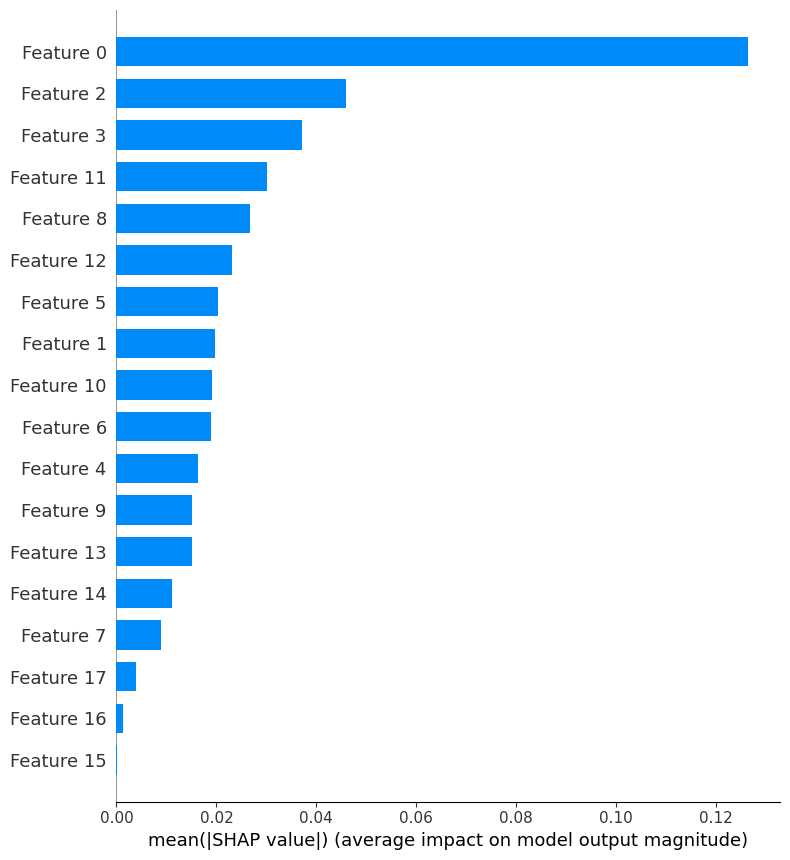

In [ ]:
shap.summary_plot(shap.TreeExplainer(tree_model).shap_values(train_X)[0], train_X, plot_type="bar")

In [ ]:
from tqdm import tqdm

N = X.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X_norm[:,list(subset) + [i]], y, reg)-value(X_norm[:, list(subset)], y, reg))
true_shapley = np.array(shap)
print(true_shapley)

  0%|                                                    | 0/18 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
true_shapley = [0.16999648, 0.00351305, 0.01231289, 0.03640622, 0.0052994,  0.02015739, 0.01889732, 0.0034261,  0.00753081, 0.00282818, 0.00419999, 0.00374287, 0.00380925, 0.00176043, 0.01024351, 0.00525661, 0.01237468, 0.01605793]

In [ ]:
len(FIFA_cols)

17

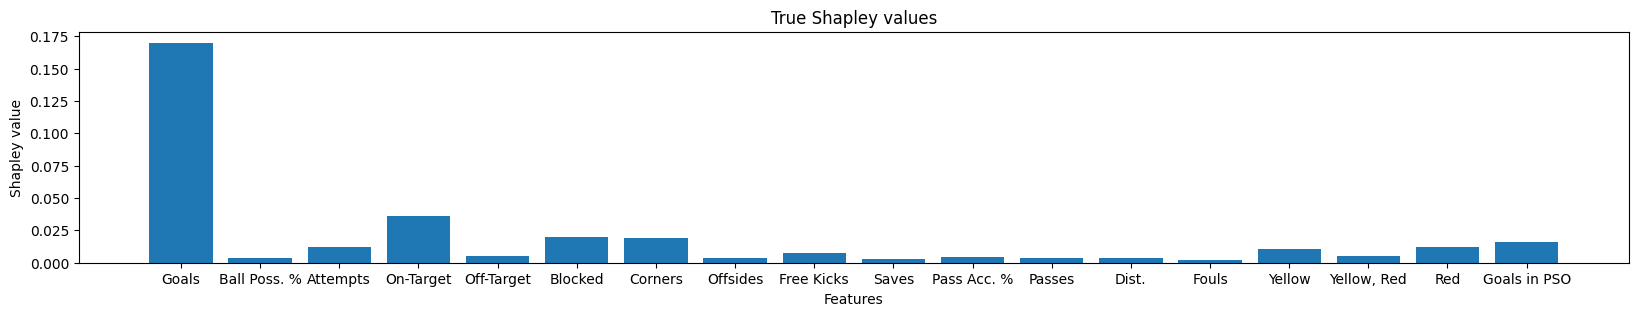

In [ ]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, true_shapley)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('True Shapley values')
plt.show()


In [ ]:
cosine_sim = cosine_similarity([true_shapley], [arr1])[0][0]
print(cosine_sim)

0.8641209091349279


0.03455267064114306


<BarContainer object of 18 artists>

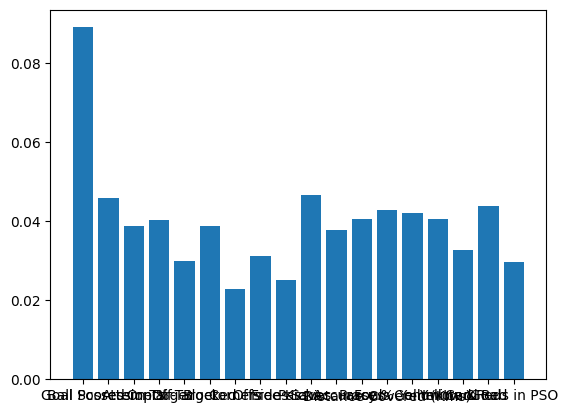

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

n = train_X.shape[1]
X2, y2, shap = main(np.array(train_X), np.array(train_y), log_reg, n**(1/np.sqrt(n)), 100)
# Compute the RMSE
#print(shap)
mse = mean_squared_error(true_shapley, shap)
rmse = np.sqrt(mse)
print(rmse)
#cosine_sim = cosine_similarity([arr1], [shap])[0][0]
#print(cosine_sim)
#cosine_sim = cosine_similarity([true_shapley], [shap])[0][0]
#print(cosine_sim)
#plt.plot(shap)
plt.bar(X.columns, shap)

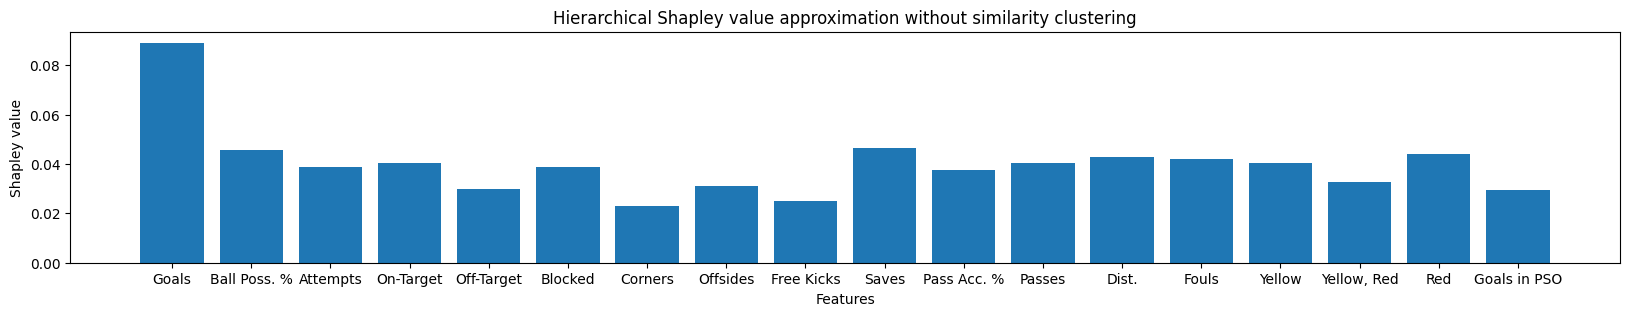

In [ ]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, shap)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation without similarity clustering')
plt.show()


0.03387213054050517


<BarContainer object of 18 artists>

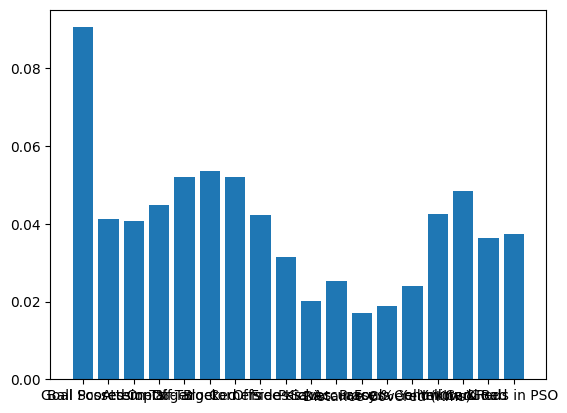

In [ ]:

n = train_X.shape[1]
X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), log_reg, n**(1/np.sqrt(n)),2, 1)
#print(shap_knn)
mse_knn = mean_squared_error(true_shapley, shap_knn)
rmse_knn = np.sqrt(mse_knn)
print(rmse_knn)

#cosine_sim = cosine_similarity([arr1], [shap_knn])[0][0]
#print(cosine_sim)
cosine_sim = cosine_similarity([true_shapley], [shap_knn])[0][0]
#print(cosine_sim)
#plt.plot(shap_knn)
plt.bar(X.columns, shap_knn)

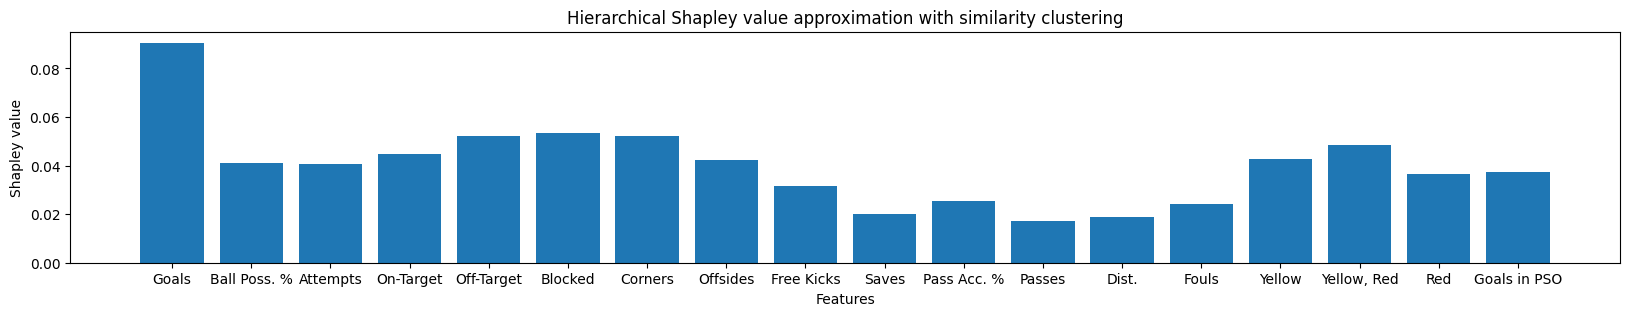

In [ ]:
# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(FIFA_cols, shap_knn)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation with similarity clustering')
plt.show()


0.05169664596974311
0.30452217520707403
0.05282786676152221
0.2816511147195261
0.046115612178430306
0.40550895864909786
0.046367251127833554
0.41701621659387467
0.04853637117560897
0.3836845202377578
0.046998177981114206
0.3663414024739454
0.04470397059450518
0.48679150147709915
0.04853275128659224
0.3791375043136047
0.040756237921510306
0.5612487368518053
0.04693009220536989
0.40439404896556924
0.043640256613679214
0.4757859231086556
0.04176727049961094
0.5145788386519278
0.04295247521370397
0.4745627794116465
0.04605700688908139
0.3918212942560426
0.04503788284460206
0.4117766928152117
0.04498747069153882
0.4088067327713423


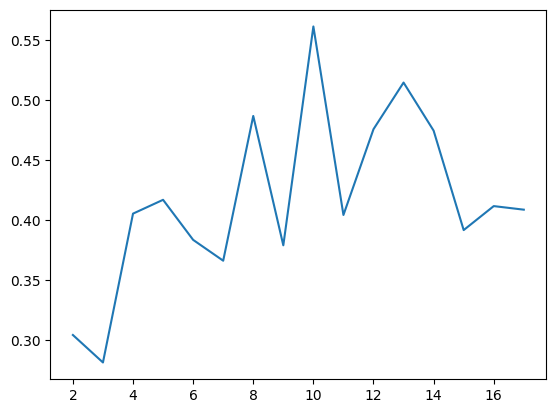

In [ ]:
import matplotlib.pyplot as pl 
k_vals = []
rmse_vals = []
sim_vals = []
for i in range(2,18):
    X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), log_reg, n**(1/np.sqrt(n)),i, 100)
    mse_knn_test = mean_squared_error(true_shapley, shap_knn)
    rmse_knn_test = np.sqrt(mse_knn_test)
    k_vals.append(i)
    rmse_vals.append(rmse_knn_test)
    print(rmse_knn_test)
    cosine_sim = cosine_similarity([true_shapley], [shap_knn])[0][0]
    sim_vals.append(cosine_sim)
    print(cosine_sim)

pl.plot(k_vals,sim_vals)


# Boston housing dataset

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

X_boston = boston.data
y_boston = boston.target


X_boston_norm = MinMaxScaler().fit_transform(X_boston)
train_X, val_X, train_y, val_y = train_test_split(X_boston_norm, y_boston, random_state=42)

#train_X, val_X, train_y, val_y = train_test_split(X_boston, y_boston, random_state=42)

train_X = X_boston_norm
val_X = X_boston_norm
train_y = y_boston
val_y = y_boston

In [ ]:
X_boston

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [ ]:
print(val_X.shape)

(127, 13)


In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)

test_predictions = reg.predict(val_X)

# Print the correct and predicted labels side by side
#for true_label, predicted_label in zip(val_y, test_predictions):
#    print(f"True label: {true_label}, Predicted label: {predicted_label}")

reg.score(val_X, val_y), reg.coef_


(0.7406426641094095,
 array([ -9.60975755,   4.64204584,   0.56083933,   2.68673382,
         -8.63457306,  19.88368651,   0.06721501, -16.22666104,
          7.03913802,  -6.46332721,  -8.95582398,   3.69282735,
        -19.01724361]))

Now we calculate exact Shapley values to calculate Mean-Squared Error(MSE) and Root-Mean Squared Error(RMSE)


In [ ]:
from tqdm import tqdm

N = X_boston.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X_boston_norm[:,list(subset) + [i]], y_boston, reg)-value(X_boston_norm[:, list(subset)], y_boston, reg))
true_shapley_boston = np.array(shap)
print(true_shapley_boston)

100%|███████████████████████████████████████████| 13/13 [01:07<00:00,  5.17s/it]

[0.02717564 0.02481086 0.03778189 0.01584259 0.03341462 0.18708535
 0.02203524 0.03027707 0.02362935 0.03678939 0.07852551 0.0229129
 0.20036224]


In [ ]:
true_shapley_boston  = [0.02717564, 0.02481086, 0.03778189, 0.01584259, 0.03341462, 0.18708535,
 0.02203524, 0.03027707, 0.02362935, 0.03678939, 0.07852551, 0.0229129,
 0.20036224]

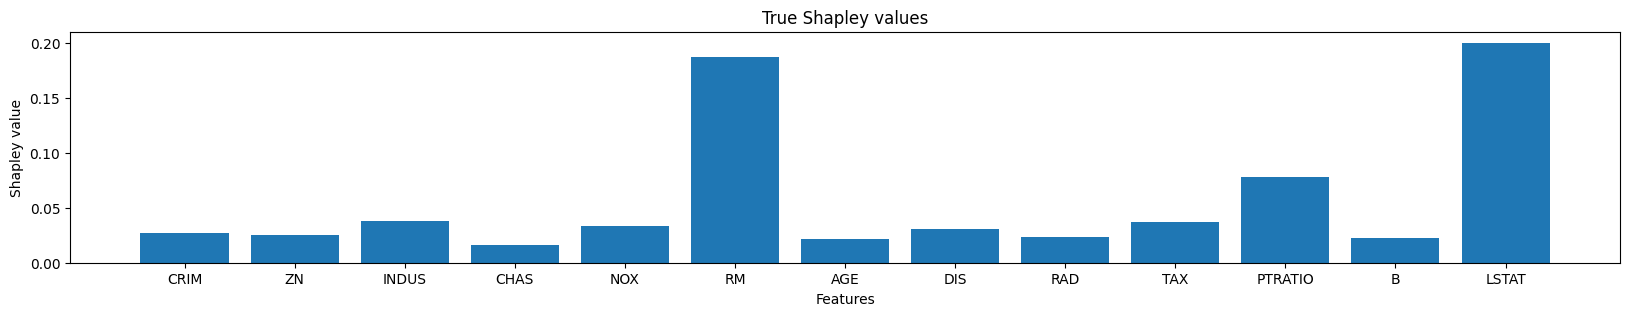

In [ ]:


# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, true_shapley_boston)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('True Shapley values')
plt.show()


0.002922978029874765


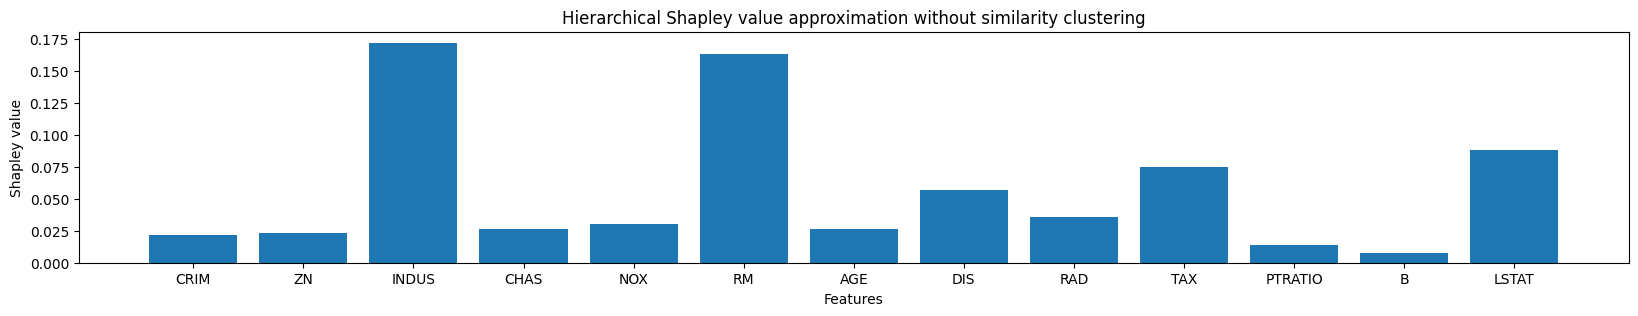

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

n = train_X.shape[1]
X2, y2, shap = main(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)), 1)
# Compute the RMSE
#print(shap)
mse = mean_squared_error(true_shapley_boston, shap)
#rmse = np.sqrt(mse)
print(mse)
#cosine_sim = cosine_similarity([true_shapley_boston], [shap])[0][0]
#print(cosine_sim)
#plt.plot(shap)


# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, shap)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation without similarity clustering')
plt.show()


In [ ]:
print(shap - true_shapley_boston)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


0.0012615059765797164


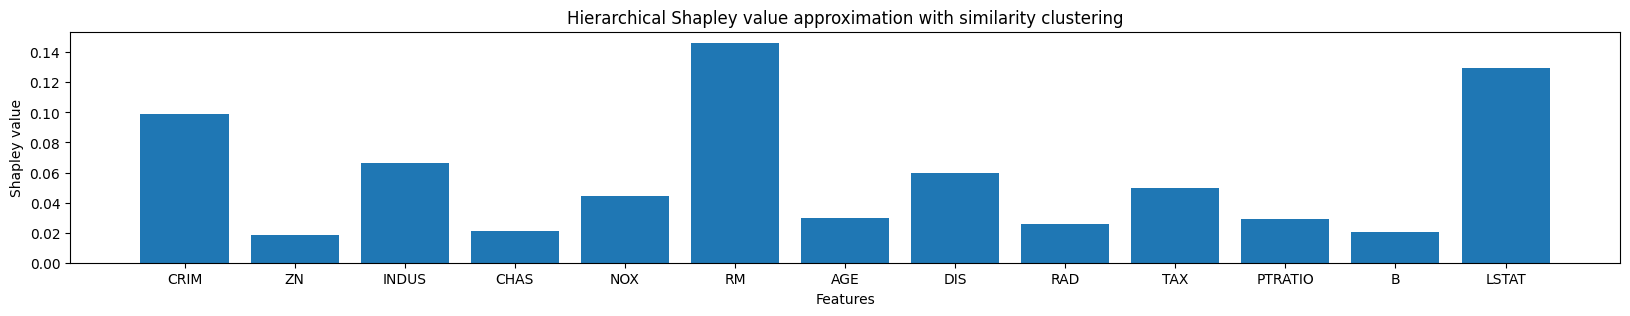

In [ ]:

n = train_X.shape[1]
X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)),2, 1)
#print(shap_knn)
mse_knn = mean_squared_error(true_shapley_boston, shap_knn)
rmse_knn = np.sqrt(mse_knn)
print(mse_knn)

cosine_sim = cosine_similarity([true_shapley_boston], [shap_knn])[0][0]
#print(cosine_sim)
#plt.plot(shap_knn)

# Plotting
plt.figure(figsize=(20, 3))  # Adjust the figure size as desired
plt.bar(boston.feature_names, shap_knn)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation with similarity clustering')
plt.show()

ValueError: ignored

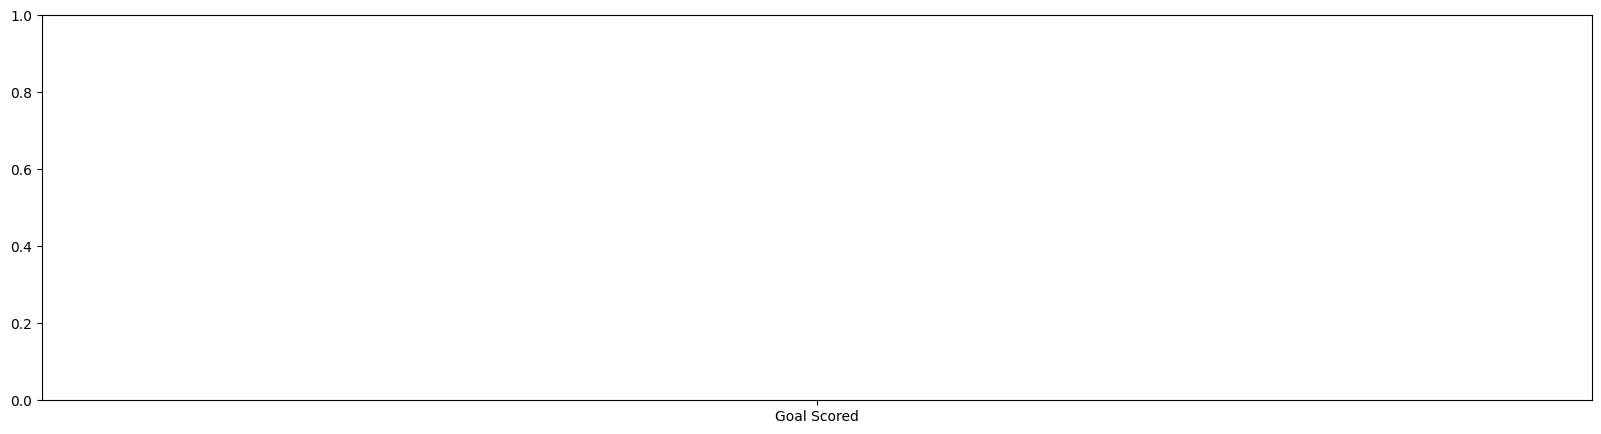

In [ ]:
# Plotting
plt.figure(figsize=(20, 5))  # Adjust the figure size as desired
plt.bar(X.columns, shap)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Values vs Columns')
plt.show()

In [ ]:
shape = (10000, 12)
n = shape[1]

#np.random.seed(1501)
X = np.random.uniform(-1,1, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row

for i in range(shape[1]):
    X[:,i] = X[:,i]*(10**i)

X = X + np.random.normal(0, .2, shape) # Add noise to input

In [ ]:
from tqdm import tqdm

N = X.shape[1]
shap = np.zeros(N)
for i in tqdm(range(N)):
    other_features = set(range(N))
    other_features.remove(i)
    subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
    for subset in subsets:
        coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
        shap[i] += coeff*(value(X[:,list(subset) + [i]], y, reg)-value(X[:, list(subset)], y, reg))
true_shapley2 = np.array(shap)
print(true_shapley2)

100%|███████████████████████████████████████████| 12/12 [01:17<00:00,  6.43s/it]

[0.07372799 0.08085109 0.08197647 0.08881009 0.0838903  0.08470378
 0.08586951 0.08522316 0.08399962 0.07807525 0.0824164  0.08147165]


In [ ]:

X1, y1, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)), 100)
X2, y2, shap_knn = main2(X, y, LinearRegression(), n**(1/np.sqrt(n)), 8)


print('shap', cosine_similarity([true_shapley2], [shap])[0][0])
print('shap_knn', cosine_similarity([true_shapley2], [shap_knn])[0][0])


shap 0.9961583895349428
shap_knn 0.9957813382356746


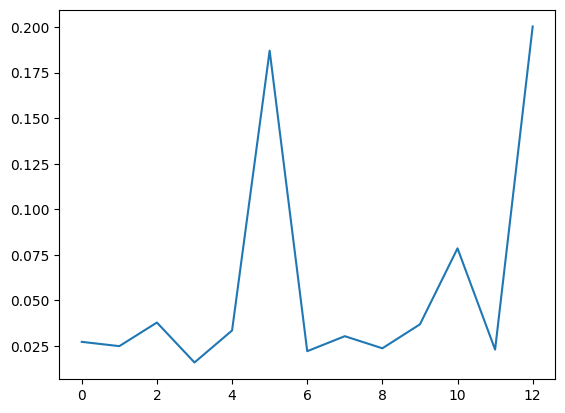

In [ ]:
plt.plot(true_shapley_boston)

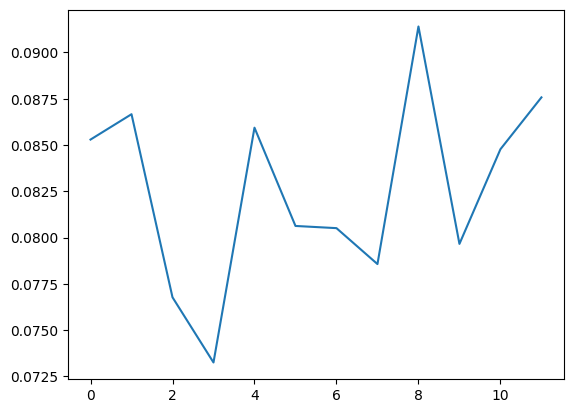

In [ ]:
plt.plot(shap)

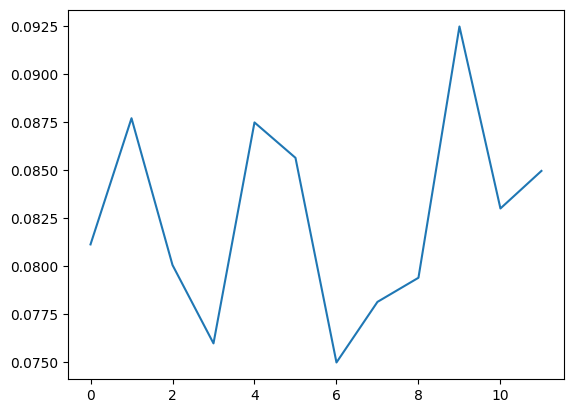

In [ ]:
plt.plot(shap_knn)

# Blogpost code

In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the data 
data = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
# Remove features with high null values 
data.drop(['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 
'LotFrontage'], inplace=True, axis=1)
# Drop null values 
data.dropna(inplace=True)
# Prepare X and Y 
X = pd.get_dummies(data)
X.drop(['SalePrice'], inplace=True, axis=1)
y = data['SalePrice']

In [ ]:
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
# Fit the Model
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

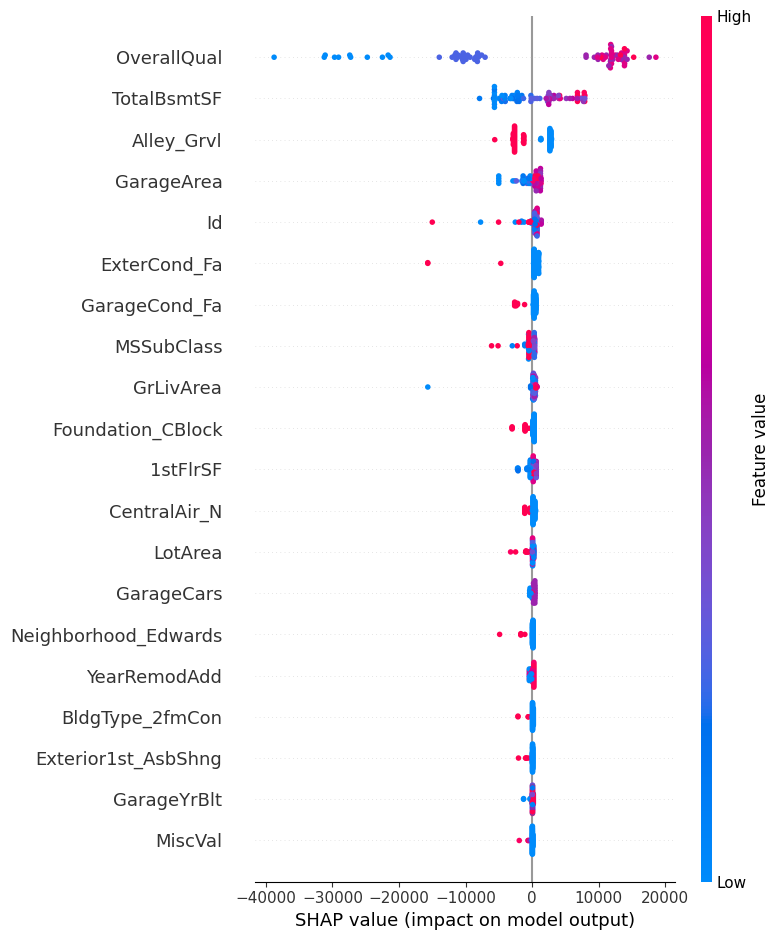

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)


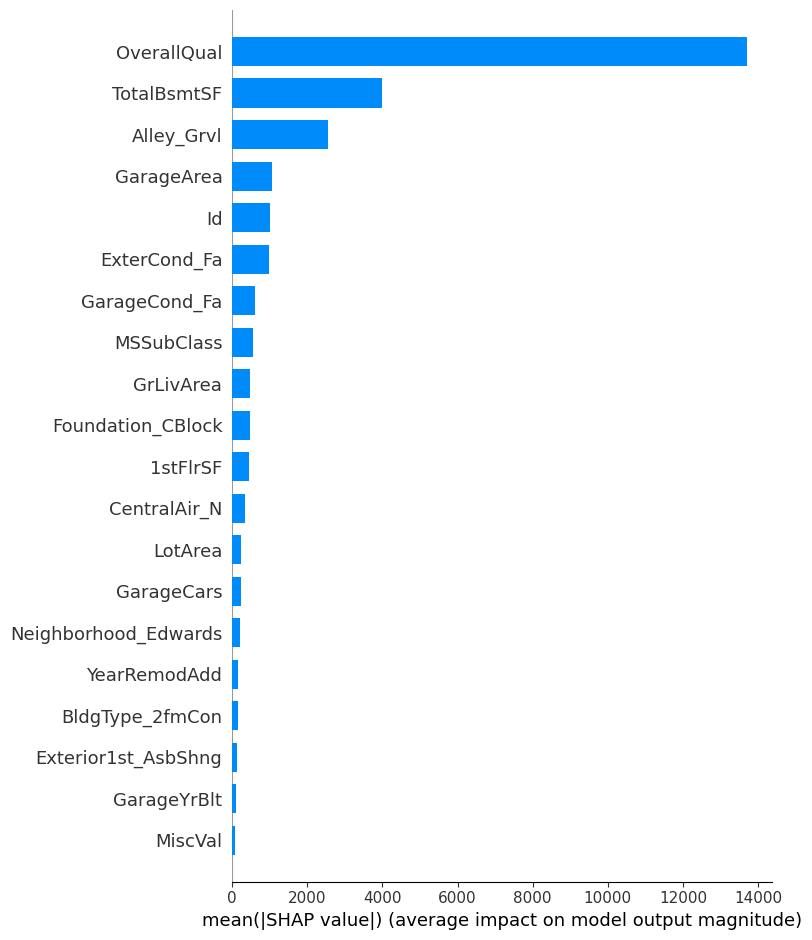

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')